In [162]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pandas_ta as ta
import quantstats as qs
qs.extend_pandas()

import numpy as np
import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn

params = {'figure.facecolor': 'w'}
plt.rcParams.update(params)

from IPython.display import display

## Helper Functions

In [2]:
# Preprocessing Functions
def handle_nan(df, method='bfill'):
    ## Fill NaN values with the earliest data
    if method == 'bfill':
        return df.fillna(method='bfill', axis=0)
    elif method == 'zerofill':
        return df.fillna(0)
    elif method == 'drop':
        return df.dropna()

def extend_price_df(df):
    '''
    Calculates returns, log_returns, and log_prices to a df with 'price' column
    '''
    df['log-price'] = np.log(df['price'])
    df['return'] = df['price'].pct_change()
    df['log-return'] = np.log(1 + df['return'])
    
    df = handle_nan(df, method='zerofill')
    
    return df
     
def gen_combined_df(df_dict, dict_keys, col, nan_handle_method='bfill'):
    for i, key in enumerate(dict_keys):
        if i == 0:
            df_buff = pd.DataFrame(index=df_dict[key].index)
        for c in col:
            df_buff[key + '_' + c] = df_dict[key][c]
    
    # Handle NaN values from combination of multiple tickers
    # Assumes that NaN values because "stock have not existed" has been handled
    df_buff = handle_nan(df_buff, method=nan_handle_method)
    df_buff = handle_nan(df_buff, method='drop')
            
    return df_buff

# Plotting Functions
def tsplot(y, lags=None, figsize=(20, 8), style='bmh', title='Time Series Analysis Plots'):
    # source: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#GARCH
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05, zero=False, auto_ylims=True)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, zero=False, auto_ylims=True)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

## Data Preparation

### Data Loading

In [3]:
# Data Directory
data_dir = '/workspace/202205_idx-trading/_data/'
lq45_dir = '/workspace/202205_idx-trading/_data/20220525_lq45/'
lq45_index_file = data_dir + '20220525_lq45_index.csv'
lq45_list = '20220525_lq45-list.txt'

# Prepare Stock Tickers
with open(data_dir + lq45_list, "r") as f:
    lq45_tickers = f.read().split('\n')

## Prepare active tickers for international codes
active_tickers = [f + '.JK' for f in lq45_tickers]
active_tickers.append('LQ45')

In [4]:
# Prepare Time Series Data
# TODO - Returns calculation need to be done after fill
nan_handle_method = 'bfill'

df_dict = {}
for ticker in tqdm(active_tickers):
    if ticker == 'LQ45':
        df_dict[ticker] = pd.read_csv(lq45_index_file)
    else:
        df_dict[ticker] = pd.read_csv(lq45_dir + ticker + '.csv')
    
    ## Take Only Date and Adjusted Close
    df_dict[ticker] = df_dict[ticker][['Date', 'Adj Close']]
    df_dict['Date'] = pd.to_datetime(df_dict[ticker]['Date'])
    df_dict[ticker].set_index(pd.DatetimeIndex(df_dict[ticker]['Date']), inplace=True)
    
    df_dict[ticker].drop('Date', axis=1, inplace=True)
    
    ## Convert Adj Close to price
    df_dict[ticker]['price'] = df_dict[ticker]['Adj Close']
    df_dict[ticker].drop('Adj Close', axis=1, inplace=True)

100%|█████████████████████████████████████████████████████| 46/46 [00:01<00:00, 29.51it/s]


In [5]:
# Separate Into In Sample and Out Sample
date_start = '2010-01-01'
date_breakpoint = '2019-01-01'

nan_cnt_threshold = 252*2

in_df = {}
out_df = {}
rmv_tickers = []
for ticker in tqdm(active_tickers):
    ## Take In Sample and Out Sample Data
    in_df[ticker] = df_dict[ticker][(df_dict[ticker].index >= date_start) & 
                                                (df_dict[ticker].index < date_breakpoint)]
    out_df[ticker] = df_dict[ticker][df_dict[ticker].index >= date_breakpoint]
    
    ## Check if there are too many NaN values
    if in_df[ticker]['price'].isna().sum() > nan_cnt_threshold:
        rmv_tickers.append(ticker)
        continue
    
    ## Handle NaN Values
    in_df[ticker] = handle_nan(in_df[ticker], method=nan_handle_method)
    out_df[ticker] = handle_nan(out_df[ticker], method=nan_handle_method)
    
    ## Extend price to other values
    in_df[ticker] = extend_price_df(in_df[ticker])
    out_df[ticker] = extend_price_df(out_df[ticker])

# Remove tickers that only have small amounts of data
active_tickers = [t for t in active_tickers if t not in rmv_tickers]

100%|█████████████████████████████████████████████████████| 46/46 [00:00<00:00, 56.71it/s]


## Data Exploration
Cointegration exploration is done on in-sample data only, so out of sample data is purely for testing.

*We will revisit cointegration testing on OOS data later on.

Steps:
- Test using existing engle-granger package. 
- Fit Ornstein-Uhlenbeck process to generate lambda (and subsequently, half life)
- Do a separate OLS to get beta of (potentially) cointegrating pair. Visualize Mean Reversion to verify.

### Engle-Granger Cointegration Test

In [141]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller

def find_coint_pairs(df_dict, tickers, form='normal', form_type='price', alpha=0.05):
    '''
    Finds cointegrated pairs from df_dict serial data, based on given tickers.
    '''
    def coint_ticker_pick(pvalue_1, pvalue_2, tickers, i, j):
        if pvalue_1 <= pvalue_2:
            pvalue = pvalue_1
            coint_tickers = [tickers[i], tickers[j]]
        else:
            pvalue = pvalue_2
            coint_tickers = [tickers[j], tickers[i]]
        
        return pvalue, coint_tickers
    
    n = len(tickers)
    pairs = []
    pvalues = []
    
    for i in range(0, n):
        for j in range(i+1, n):
            
            comb_df = gen_combined_df(df_dict, [tickers[i], tickers[j]], [form_type])
            S1 = comb_df[tickers[i] + "_" + form_type]
            S2 = comb_df[tickers[j] + "_" + form_type]
                
            if(form == 'normal'):
                result_1 = coint(S2, S1)
                pvalue_1 = result_1[1]
                
                result_2 = coint(S1, S2)
                pvalue_2 = result_2[1]
                
                pvalue, coint_tickers = coint_ticker_pick(pvalue_1, pvalue_2, tickers, i, j)
                
            elif(form == 'ratio'):
                result_1 = adfuller(S1/S2)
                pvalue_1 = result_1[1]
                
                result_2 = adfuller(S2/S1)
                pvalue_2 = result_2[1]
                
                pvalue, coint_tickers = coint_ticker_pick(pvalue_1, pvalue_2, tickers, i, j)
                
            if pvalue < alpha:
                pairs.append(coint_tickers)
                pvalues.append(pvalue)
                      
    return pairs, pvalues

def calc_beta_ols(S2, S1, form_type='price'):
    '''
    Calculate beta from two series by doing regression.
    '''
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1[form_type]
    b = results.params[form_type].values[0]
    
    return b

def calc_half_life(S, form_type='price'):
    '''
    Calculate half life from a price series
    '''
    S_lag = S.shift(periods=1).iloc[1:]
    S_diff = S.iloc[1:] - S_lag

    S_lag = sm.add_constant(S_lag)
    results = sm.OLS(S_diff, S_lag).fit()
    S_lag = S_lag[form_type]
    lbd = results.params[form_type].values[0]

    hl = -np.log(2) / lbd
    
    return hl, lbd

In [142]:
# Prepare LQ45 Stock Indexes of the Same Group
stock_groups = {
    "energy_and_mining": ['BRPT.JK', 'HRUM.JK', 'MEDC.JK', 'PGAS.JK', 'TPIA.JK', 'ADRO.JK', 'ITMG.JK', 'PTBA.JK', 'INCO.JK', 'MDKA.JK', 'ANTM.JK'],
    "retail": ['AMRT.JK', 'UNVR.JK', 'ERAA.JK', 'ASII.JK'],
    "food_agri": ['CPIN.JK', 'JPFA.JK', 'ICBP.JK', 'INDF.JK'],
    "paper": ['TKIM.JK', 'INKP.JK'],
    "finance": ['BBCA.JK', 'BBNI.JK', 'BBRI.JK', 'BBTN.JK', 'BMRI.JK', 'BFIN.JK'],
    "media": ['EMTK.JK', 'MNCN.JK'],
    "telcom": ['EXCL.JK', 'TLKM.JK', 'TBIG.JK', 'TOWR.JK'],
    "tobacco": ['GGRM.JK', 'HMSP.JK'],
    "construction": ['INTP.JK', 'PTPP.JK', 'SMGR.JK', 'UNTR.JK', 'WIKA.JK', 'WSKT.JK'],
    "medical": ['KLBF.JK', 'MIKA.JK']
}

# Filter to only those that are active
for key, val in stock_groups.items():
    stock_groups[key] = [t for t in val if t in active_tickers]

In [143]:
# Search for Coint Pair on Different Forms
forms = ['normal', 'ratio']
form_types = ['price', 'log-price']

pair_l = []
for key, val in tqdm(stock_groups.items()):
    tickers = val
    tickers.append('LQ45')
    
    for f in forms:
        for ft in form_types:
    
            pairs, pvalues = find_coint_pairs(in_df, tickers, form=f, form_type=ft, alpha=0.025)
            for pair, pvalue in zip(pairs, pvalues):
                pair_l.append({
                                'ticker_1': pair[0],
                                'ticker_2': pair[1],
                                'form': f,
                                'form_type': ft,
                                'eg_pvalue': pvalue
                            })
    
pair_df = pd.DataFrame(pair_l) 

100%|█████████████████████████████████████████████████████| 10/10 [02:07<00:00, 12.71s/it]


In [144]:
# Calculate Half-Life

pair_l = []
for _, row in pair_df.iterrows():
    # Regression to get Beta for Price Spread Model
    ## Combine Series
    comb_df = gen_combined_df(in_df, [row['ticker_1'], row['ticker_2']], [row['form_type']])
    
    ## Rename Columns
    S1 = comb_df[row['ticker_1'] + "_" + row['form_type']]
    S1.name = row['form_type']
    S2 = comb_df[row['ticker_2'] + "_" + row['form_type']]
    S2.name = row['form_type']
    
    if row['form'] == 'normal':
        b = calc_beta_ols(S2, S1, form_type=[row['form_type']])
        spread = S2 - b * S1
        
    elif row['form'] == 'ratio':
        b = 0
        spread = S1 / S2

    # Ornstein-Uhlenbeck Formula to Calculate Half Life
    hl, lbd = calc_half_life(spread, form_type=[row['form_type']])
    
    pair_l.append({
                    'beta': b,
                    'half_life': hl,
                    'lambda': lbd
                    })
    
pair_df = pd.concat([pair_df, pd.DataFrame(pair_l)], axis=1)

In [149]:
# Filter Strategies that Takes too Long to be Profitable
final_pair_df = pair_df[(pair_df['half_life'] < 60) & (pair_df['lambda'] < 0)].reset_index()

In [150]:
display(final_pair_df)

,index,ticker_1,ticker_2,form,form_type,eg_pvalue,beta,half_life,lambda
0,2,MEDC.JK,INCO.JK,normal,log-price,0.004992,0.470747,59.560364,-0.011638
1,13,AMRT.JK,ASII.JK,normal,log-price,0.003506,0.479771,48.946634,-0.014161
2,25,BBCA.JK,BBRI.JK,normal,price,0.009189,0.681382,28.405973,-0.024401
3,26,BBRI.JK,BMRI.JK,normal,price,0.005884,1.885591,24.668635,-0.028098
4,27,BBCA.JK,BBRI.JK,normal,log-price,0.000085,0.995885,18.282565,-0.037913
5,28,BBCA.JK,BMRI.JK,normal,log-price,0.007078,0.866222,42.148736,-0.016445
6,31,BBRI.JK,BMRI.JK,normal,log-price,0.002544,0.867258,43.154140,-0.016062
7,32,BBCA.JK,BBRI.JK,ratio,price,0.000004,0.000000,18.079666,-0.038338
8,35,BBCA.JK,BBRI.JK,ratio,log-price,0.000014,0.000000,18.810227,-0.036849


### Visualization

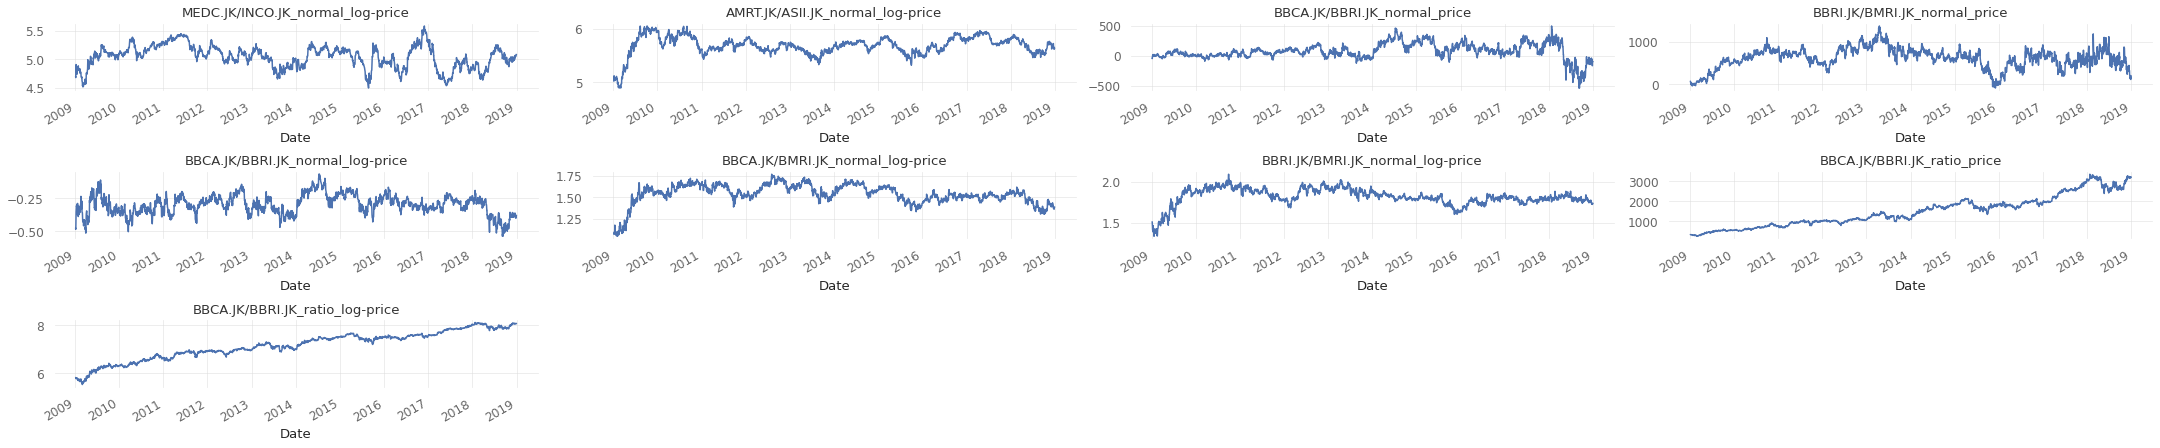

In [161]:
# Visualize Price Spread
fig = plt.figure(figsize=(30,20))

for i, row in final_pair_df.iterrows():
    # Combine Series
    comb_df = gen_combined_df(in_df, [row['ticker_1'], row['ticker_2']], [row['form_type']])
    S1 = comb_df[row['ticker_1'] + "_" + row['form_type']]
    S2 = comb_df[row['ticker_2'] + "_" + row['form_type']]
    
    # Calculate Spread
    spread = S2 - row['beta'] * S1
    
    # Plot on Specific Axis
    ax = plt.subplot(10, 4, i+1)
    ax.set_title(row['ticker_1'] + "/" + row['ticker_2'] + "_" + row['form'] + "_" + row['form_type'])
    spread.plot(ax=ax)

plt.tight_layout()
plt.show()

In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljungbox

def get_arima_best_order(df_logret, pq_rng=range(5), d_rng=range(2)):
    best_aic = np.inf 
    arima_best_order = None
    arima_best_mdl = None

    for p in tqdm(pq_rng):
        for d in d_rng:
            for q in pq_rng:
                tmp_mdl = smt.ARIMA(df_logret, 
                                    order=(p,d,q)).fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    arima_best_order = (p, d, q)
                    arima_best_mdl = tmp_mdl
    arima_resid = arima_best_mdl.resid
    print(arima_best_mdl.summary())
    
    return arima_best_order, arima_resid

In [ ]:
# Run ARIMA Fitting
arima_best_order, arima_resid = get_arima_best_order(in_df[ticker]['log_return'])

## Test Ljungbox Fit
lb_pval = ljungbox(arima_resid, lags=[arima_best_order[2]])['lb_pvalue'].values[0]
lb_pval_2 = ljungbox(arima_resid**2, lags=[arima_best_order[2]])['lb_pvalue'].values[0]
print(f'Ljung-Box P-Value on Residual        : {lb_pval}')
print(f'Ljung-Box P-Value on Squared Residual: {lb_pval_2}')

 60%|█████████████████████████████████████████▍                           | 3/5 [00:18<00:12,  6.18s/it]


In [ ]:
# ARIMA Model Summary
_ = tsplot(arima_resid, lags=30)
_ = tsplot(arima_resid ** 2, lags=30, title='Squared Analysis Plot')

# TODO - Find other goodness of fit tests

In [ ]:
import os
import subprocess

def get_garch_1d_forecast(df_logret, arima_best_order):
    # Prepare Input Files
    ## ARIMA Model Best Order Fle
    with open("arima_model.txt", "w+") as f:
        for item in arima_best_order:
            f.writelines(str(item) + "\n")
    
    ## Log Return File
    df_logret.to_csv("log_ret.csv", index=False)
    
    # Call R Script for fitting and forecasting garch
    garch_script_path = "./20220621_garch.r"
    subprocess.call("/usr/bin/Rscript " + garch_script_path, shell=True)
    
    ## Get garch residuals and forecast
    garch_resid = pd.read_csv("r-garch-resid.csv")['V1']
    
    with open("r-garch-1d-forecast.txt", "r") as f:
        garch_1d_forecast = float(f.read().rstrip('\n'))

    os.remove("arima_model.txt")
    os.remove("log_ret.csv")
    os.remove("r-garch-resid.csv")
    os.remove("r-garch-1d-forecast.txt")
    
    return  garch_1d_forecast, garch_resid

In [ ]:
# Run Garch 1d forecast
garch_1d_forecast, garch_resid = get_garch_1d_forecast(in_df[ticker]['log_return'], arima_best_order)

## Test Ljungbox Fit
lb_pval = ljungbox(garch_resid, lags=[arima_best_order[2]])['lb_pvalue'].values[0]
lb_pval_2 = ljungbox(garch_resid**2, lags=[arima_best_order[2]])['lb_pvalue'].values[0]
print(f'Ljung-Box P-Value on Residual        : {lb_pval}')
print(f'Ljung-Box P-Value on Squared Residual: {lb_pval_2}')

In [ ]:
# GARCH Model Summary
_ = tsplot(garch_resid, lags=30)
_ = tsplot(garch_resid**2, lags=30, title='Squared Analysis Plot')

## Strategy